In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_absolute_error , mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from tensorflow import keras
from keras.layers import Dense,Activation,Dropout,Input,LSTM
from keras.models import Sequential
from keras.callbacks import EarlyStopping


In [2]:
df = pd.read_csv(r"D:\python_jupty\機器學習作業\2023大里訓練用.csv")
df_test = pd.read_csv(r"D:\python_jupty\機器學習作業\大里補值完AE專用_2022.csv")

In [3]:
df

,time,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RH,SO2,THC,WD_HR(SIN),WD_HR(COS),WD_HR,WS_HR,aqi,Index
0,2023/1/1 00:00,17.9,2.21,0.45,0.13,0.8,14.0,14.9,13.9,30,14,81,1.9,2.34,-0.965926,0.258819,285,0.2,28,1
1,2023/1/1 01:00,17.7,2.18,0.42,0.12,0.6,15.7,16.4,12.4,27,21,85,1.2,2.30,-0.656059,0.754710,319,0.2,31,2
2,2023/1/1 02:00,17.6,2.22,0.46,0.14,0.4,15.0,15.5,11.3,29,20,86,1.1,2.36,0.069756,-0.997564,176,0.1,38,3
3,2023/1/1 03:00,17.2,2.20,0.50,0.14,1.3,17.9,19.2,4.3,36,27,89,1.1,2.34,0.694658,-0.719340,136,0.8,44,4
4,2023/1/1 04:00,17.0,2.22,0.46,0.13,1.1,15.8,17.0,5.7,32,28,90,0.9,2.35,-0.970296,-0.241922,256,0.6,54,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023/12/31 19:00,21.7,2.18,0.57,0.08,0.9,20.3,21.3,37.0,52,40,69,1.3,2.26,-0.374607,0.927184,338,1.5,70,8756
8756,2023/12/31 20:00,20.9,2.20,0.58,0.08,0.9,20.2,21.1,38.7,52,40,70,1.4,2.28,-0.390731,0.920505,337,1.3,79,8757
8757,2023/12/31 21:00,20.3,2.20,0.56,0.07,0.8,19.3,20.1,41.2,53,43,71,1.4,2.27,-0.207912,0.978148,348,1.6,86,8758
8758,2023/12/31 22:00,20.0,2.21,0.55,0.06,0.7,18.2,18.9,40.5,42,39,70,1.5,2.27,0.156434,0.987688,9,1.5,93,8759


In [4]:
X = df.drop(columns=['time','aqi','Index','WD_HR'])
X_test = df_test.drop(columns=['time','aqi','WD_HR','WIND_SPEED'])
X.shape[1],X_test.shape[1]

(16, 16)

In [5]:
numerical_columns = ['AMB_TEMP', 'CH4', 'CO', 'NMHC', 'NO', 'NO2', 'NOx', 'O3', 'PM10', 'PM2.5', 'RH', 'SO2', 'THC', 'WD_HR(SIN)', 'WD_HR(COS)', 'WS_HR']

# 初始化標準化器
scaler = StandardScaler()

# 對數值型欄位進行標準化
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])
X_test[numerical_columns] = scaler.fit_transform(X_test[numerical_columns])
# 檢查標準化後的資料
print(X.head())

   AMB_TEMP       CH4        CO      NMHC        NO       NO2       NOx  \
0 -1.329631  0.242989  0.601994  0.176633 -0.373451  0.274367  0.059704   
1 -1.368452  0.105041  0.412970  0.078072 -0.426255  0.521010  0.226531   
2 -1.387862  0.288972  0.665002  0.275194 -0.479058  0.419451  0.126435   
3 -1.465503  0.197007  0.917035  0.275194 -0.241442  0.840195  0.537943   
4 -1.504323  0.288972  0.665002  0.176633 -0.294246  0.535518  0.293263   

         O3      PM10     PM2.5        RH       SO2       THC  WD_HR(SIN)  \
0 -0.745605 -0.115930 -0.114797  0.516088  0.640755  0.249178   -0.947737   
1 -0.825246 -0.276752  0.559857  0.799474 -0.370274  0.110426   -0.478853   
2 -0.883650 -0.169537  0.463478  0.870321 -0.514706  0.318555    0.619435   
3 -1.255311  0.205716  1.138131  1.082861 -0.514706  0.249178    1.565023   
4 -1.180979 -0.008714  1.234511  1.153707 -0.803572  0.283867   -0.954350   

   WD_HR(COS)     WS_HR  
0    0.264676 -1.226102  
1    1.011380 -1.226102  
2   -1.6

In [6]:
X_test.head()

,AMB_TEMP,CH4,CO,NMHC,NO,NO2,NOx,O3,PM10,PM2.5,RH,SO2,THC,WD_HR(SIN),WD_HR(COS),WS_HR
0,-1.726105,0.332494,0.639721,0.347241,-0.278228,1.345419,0.819002,-1.006866,0.707848,1.318070,0.290616,1.027459,0.382414,-1.070016,-0.284090,-0.005585
1,-1.782550,0.511123,0.701702,0.347241,-0.193942,1.272363,0.808694,-0.990900,0.949155,1.708804,0.440784,1.027459,0.526972,-1.058868,-0.076752,-0.450857
2,-1.650845,0.261042,0.701702,0.080644,-0.236085,1.345419,0.839618,-0.873810,0.707848,1.415753,0.290616,0.862737,0.237856,0.747881,1.202736,-1.230083
3,-1.707290,2.511774,0.825665,0.524972,-0.172870,1.286974,0.819002,-1.081378,0.768175,1.708804,0.365700,0.533295,2.203846,1.332290,-1.477176,-1.118765
4,-1.744920,1.154190,0.949628,0.880436,0.016773,1.491530,1.056082,-1.288945,1.069808,2.099538,0.515868,0.533295,1.220851,-0.065644,-1.656564,-1.118765


In [7]:
import pickle
with open('scaler_AE_test.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [8]:
from tensorflow.keras.models import load_model


loaded_encoder = load_model(r"D:\python_jupty\機器學習作業\encoder_model_v2\encoder_model_v2.keras")
X_test_encoded_loaded = loaded_encoder.predict(X_test)
X_encoded_loaded = loaded_encoder.predict(X)
print(pd.DataFrame(X_encoded_loaded).head())

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 467us/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 500us/step
           0         1         2          3
0   8.964522  5.189375  5.555481   6.627413
1  12.519225  4.721141  7.804574   5.745637
2  15.630527  7.808340  8.286627  11.181902
3  14.318752  6.583022  7.211484  10.763042
4  13.749807  5.455493  6.634918   9.247779


In [9]:
# 將壓縮特徵轉為 DataFrame
X_encoded_df = pd.DataFrame(X_encoded_loaded, columns=[f'encoded_{i}' for i in range(X_encoded_loaded.shape[1])])

# 合併壓縮特徵與目標變數
data_with_encoded = pd.concat([X_encoded_df, df[['aqi']].reset_index(drop=True)], axis=1)

# 顯示合併後的資料
print(data_with_encoded.head())


X_test_encoded_df = pd.DataFrame(X_test_encoded_loaded, columns=[f'encoded_{i}' for i in range(X_test_encoded_loaded.shape[1])])

# 合併壓縮特徵與目標變數
test_data_with_encoded = pd.concat([X_test_encoded_df, df_test[['aqi']].reset_index(drop=True)], axis=1)

# 顯示合併後的資料
print(test_data_with_encoded.head())

   encoded_0  encoded_1  encoded_2  encoded_3  aqi
0   8.964522   5.189375   5.555481   6.627413   28
1  12.519225   4.721141   7.804574   5.745637   31
2  15.630527   7.808340   8.286627  11.181902   38
3  14.318752   6.583022   7.211484  10.763042   44
4  13.749807   5.455493   6.634918   9.247779   54
   encoded_0  encoded_1  encoded_2  encoded_3  aqi
0   9.871610   3.973373   6.555418   9.268191   54
1  10.770638   3.443215   6.561362   9.720036   60
2   8.249769   2.937101   5.584232   7.793545   67
3  16.489134   4.720790   5.837266  12.274814   71
4  16.864832   5.975561   8.420634  14.916449   75


In [10]:
df_selected = data_with_encoded#去掉的feature
df_selected_test = test_data_with_encoded#去掉的feature
sel_data = 'aqi'  

# Train Test split

In [11]:
import math


time_steps = 6
train = df_selected

test = df_selected_test

In [12]:
train_temp = train.to_numpy()
test_temp = test.to_numpy()

scaler = MinMaxScaler(feature_range=(0, 1))

train_np= scaler.fit_transform(train_temp)
test_np= scaler.transform(test_temp)

In [13]:
import pickle
with open('scaler_MINMAX_AE_1.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [14]:
print(train_np)

print(test_np.shape)

[[0.19458751 0.22192391 0.17304153 0.20950408 0.1242236 ]
 [0.2717473  0.20189984 0.24309604 0.18162961 0.14285714]
 [0.33928246 0.33392408 0.25811097 0.35347943 0.1863354 ]
 ...
 [0.16646006 0.         0.20152723 0.14136908 0.48447205]
 [0.17001759 0.         0.20887101 0.10894875 0.52795031]
 [0.1507286  0.0064784  0.19543718 0.09993823 0.54658385]]
(8760, 5)


# Train

In [15]:
from tqdm import tqdm
X_train = []
y_train = []

for i in tqdm(range(len(train_np) - time_steps)):
    X_train.append(train_np[i:i+time_steps])
    y_train.append(train_np[i+time_steps])

X_train = np.array(X_train)
y_train = np.array(y_train)

print(X_train[0])
print(y_train[0])

100%|██████████| 8754/8754 [00:00<00:00, 1752180.25it/s]

[[0.19458751 0.22192391 0.17304153 0.20950408 0.1242236 ]
 [0.2717473  0.20189984 0.24309604 0.18162961 0.14285714]
 [0.33928246 0.33392408 0.25811097 0.35347943 0.1863354 ]
 [0.31080856 0.28152329 0.22462253 0.34023855 0.22360248]
 [0.29845881 0.23330444 0.20666372 0.29233843 0.28571429]
 [0.3310304  0.31115053 0.2142037  0.30972019 0.32919255]]
[0.35305839 0.29277572 0.22643527 0.37314838 0.32919255]


# Test

In [16]:
x_test = []
y_test = []


for i in tqdm(range(len(test_np)-time_steps)):
    x_test.append(test_np[i:i+time_steps])


y_test= test['aqi']

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_test.shape)
print(y_test.shape)



100%|██████████| 8754/8754 [00:00<00:00, 2903902.03it/s]

(8754, 6, 5)
(8760,)


# Model

In [17]:
opt = keras.optimizers.Adam(learning_rate=0.005)


model = Sequential()
model.add(Input(shape=(X_train.shape[1],  X_train.shape[2])))  

model.add(LSTM(32,return_sequences=True,activation='relu') )
model.add(LSTM(16,return_sequences=False,activation='relu') )
 
model.add( Dense(X_train.shape[2],activation='relu') )
model.compile(optimizer=opt, loss='mse')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=5)


model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 6, 32)          │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,085 (31.58 KB)

 Trainable params: 8,085 (31.58 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:

tt = 50
history = model.fit(X_train,y_train,batch_size=20,validation_split=0.1,epochs=tt,callbacks=[es],verbose=1,shuffle=False)

Epoch 1/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0471 - val_loss: 0.0289
Epoch 2/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0267 - val_loss: 0.0262
Epoch 3/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0137 - val_loss: 0.0089
Epoch 4/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 5/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 6/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0054 - val_loss: 0.0057
Epoch 7/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0051 - val_loss: 0.0056
Epoch 8/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0050 - val_loss: 0.0053
Epoch 9/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 10/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0047 - val_loss: 0.0048
Epoch 11/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0046 - val_loss: 0.0047
Epoch 12/50
394/394 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

# Predict

In [19]:
import random

j =6
num_steps_to_show = 3
initial_sequence = []
initial_sequence.append(test_np[j-time_steps:j])
initial_sequence = np.array(initial_sequence)


In [20]:
sequence = []
temp = X_train.shape[2]
for i in range(num_steps_to_show):
    new_prediction = model.predict(initial_sequence)

    initial_sequence = initial_sequence[0][1:]
    
    initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])
    sequence.append(new_prediction[0][temp-1])



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [21]:
sc = MinMaxScaler(feature_range=(0, 1))
y_test= y_test.reshape(-1, 1)
sc.fit(y_test)
with open('scaler_MINMAX_inverse_AE_2.pkl', 'wb') as f:
    pickle.dump(sc, f)
sequence = sc.inverse_transform(np.array(sequence).reshape(num_steps_to_show,1))

In [22]:
sequence=sequence.astype(int)

In [23]:
mse =mean_squared_error(y_test[j:j+num_steps_to_show],sequence)
mse
rmse = np.sqrt(mse)
print('rmse:'   ,rmse)
print('mse:',mse)


rmse: 4.69041575982343
mse: 22.0


# 圖

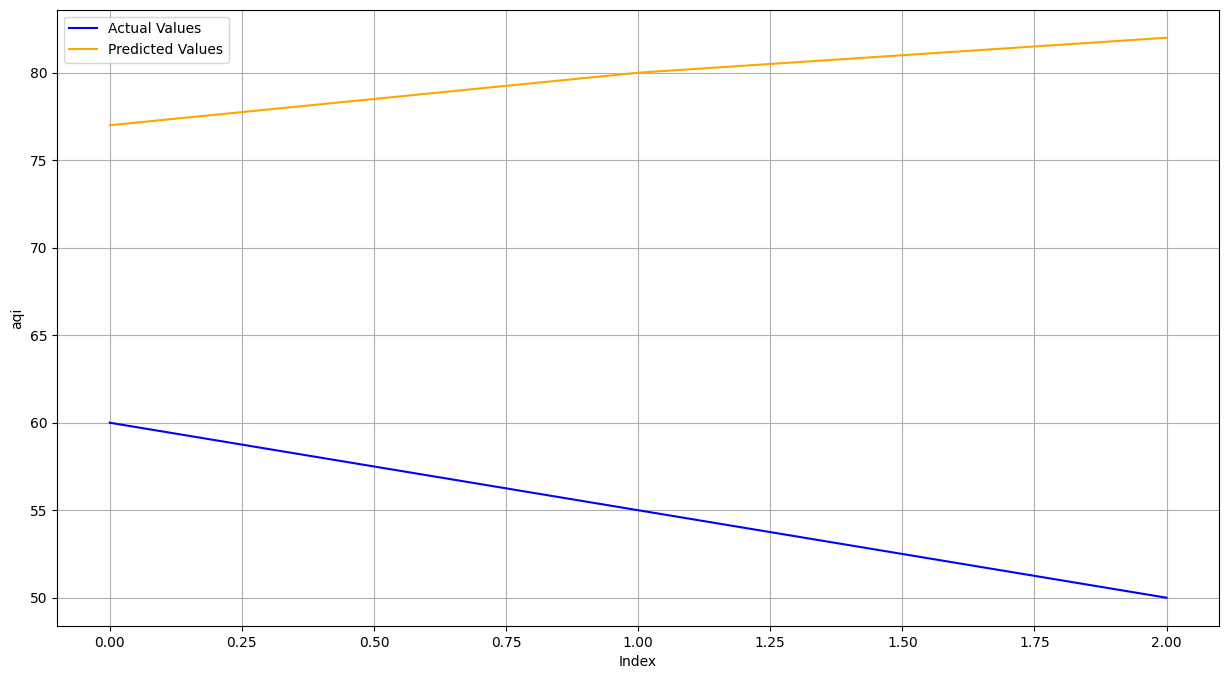

In [24]:

plt.figure(figsize=(15, 8))
plt.plot(y_test[j+time_steps:j+time_steps+num_steps_to_show], label='Actual Values', color='blue', linestyle='-')
plt.plot(sequence[:num_steps_to_show], label='Predicted Values', color='orange', linestyle='-')
plt.xlabel('Index')
plt.ylabel('aqi')
plt.legend()
plt.grid(True)
plt.show()

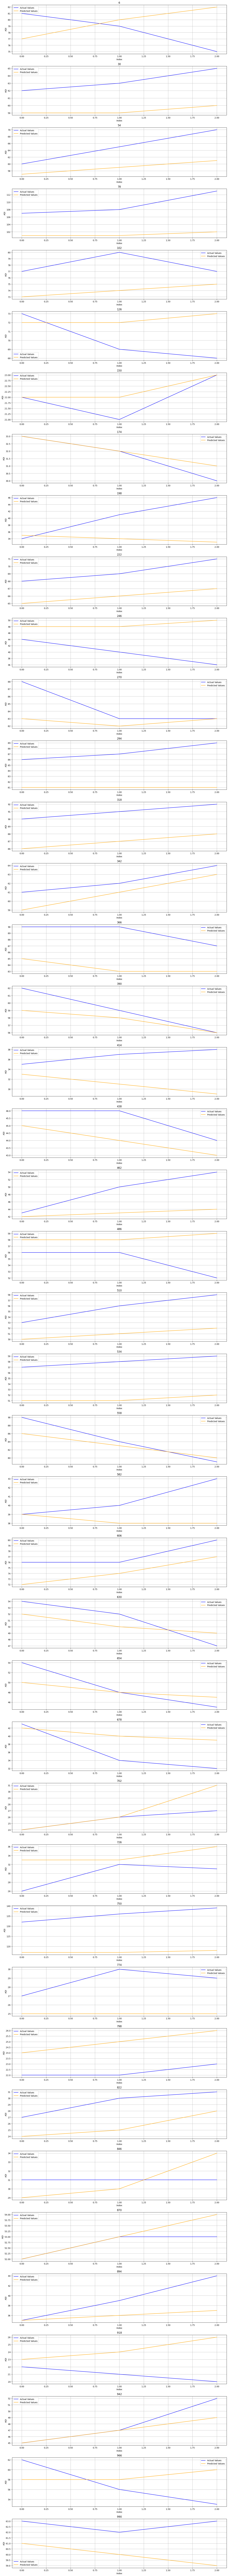

In [25]:
k=0
plt.figure(figsize=(15, 200))
while(True):
        initial_sequence = []
        initial_sequence.append(test_np[j-time_steps:j])

        initial_sequence = np.array(initial_sequence)
        sequence = []
        temp = X_train.shape[2]
        for i in range(num_steps_to_show):
            new_prediction = model.predict(initial_sequence,verbose=0)

            initial_sequence = initial_sequence[0][1:]
            
            initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])
            sequence.append(new_prediction[0][temp-1])
        
        sequence = sc.inverse_transform(np.array(sequence).reshape(num_steps_to_show,1))
        sequence=sequence.astype(int)
        # mse =mean_squared_error(y_test[j+time_steps:j+time_steps+num_steps_to_show],sequence)
        # rmse = np.sqrt(mse)
        # print('rmse:',rmse)
        # print('mse:',mse)

        
        plt.subplot(50, 1, k + 1 )
        k=k+1
        plt.plot(y_test[j :j + num_steps_to_show], label='Actual Values', color='blue', linestyle='-')
        plt.plot(sequence, label='Predicted Values', color='orange', linestyle='-')
        plt.title(f'{j}')
  
        plt.xlabel('Index')
        plt.ylabel('AQI')
        plt.legend() 
        plt.grid(True)
        j=j+24
        if(j>1000):
            break
plt.tight_layout()
plt.show()

In [26]:
j=6
k=0
total_rmse=0
while(True):
        initial_sequence = []
        initial_sequence.append(test_np[j-time_steps:j])

        initial_sequence = np.array(initial_sequence)
        sequence = []
        temp = X_train.shape[2]
        for i in range(num_steps_to_show):
            new_prediction = model.predict(initial_sequence,verbose=0)

            initial_sequence = initial_sequence[0][1:]
                   
            initial_sequence = np.append(initial_sequence,new_prediction,axis=0).reshape(-1,time_steps,X_train.shape[2])

            sequence.append(new_prediction[0][temp-1])
            if(new_prediction[0][temp-1]>200):
                print(j+i)
        
        sequence = sc.inverse_transform(np.array(sequence).reshape(num_steps_to_show,1))
        sequence=sequence.astype(int)
        mse =mean_squared_error(y_test[j:j+num_steps_to_show],sequence)
        rmse = np.sqrt(mse)
        total_rmse+=rmse
        k=k+1
        j=j+24
        if(j>8760):
            break
print('rmse:',total_rmse/k)


rmse: 4.40775106803853


In [27]:
# model.save("LSTM_AE_V2_6_3_rmse_43.keras")
# model.save("LSTM_AE_V3_6_3_rmse_68.keras")
# model.save("LSTM_AE_V1_6_3_rmse_117.keras")